In [1]:
import time
import pandas as pd
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup


from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import matplotlib.pyplot as plt
import numpy as np
import math

import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

#to display all rows columns 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

### Step1: Download ChromeDriver:
(check chrom version)
https://chromedriver.chromium.org/downloads

### Step2: Change the chrome drive path below to your local folder

In [2]:
# Fielding Positions CSV in Cricket, divided into quadrants
fieldingPositions = pd.read_csv("C:/Users/utkar/OneDrive/Desktop/Analytics/Data/FieldingPositions.csv")
Positions = fieldingPositions.Position.tolist()

In [3]:
fieldingPositions.head()

,Quadrant,Position
0,1,Fine Third Man
1,1,Deep Third Man
2,1,Square Third Man
3,1,Third Man
4,1,Short Third man


In [4]:
def perform_scraping(innings):
    ##### Web scrapper for infinite scrolling page #####
    driver_path = r"C:\Users\utkar\OneDrive\Desktop\Analytics\chromedriver_win32\chromedriver.exe"
    driver = webdriver.Chrome(executable_path=driver_path)

    # Scrape Ball by ball data from any cricinfo commentary
    match_url = "https://www.espncricinfo.com/series/ipl-2021-1249214/chennai-super-kings-vs-kolkata-knight-riders-final-1254117/ball-by-ball-commentary"
    driver.get(match_url)

    # click drop down menu
    dd = driver.find_element_by_css_selector(".dropdown-container")
    dd.click()

    time.sleep(2)
    # selct item from a drop down menu
    xpath_string = f"//div[@class='ci-dd__menu']/ul[1]/li[{innings}]"
    driver.find_element(By.XPATH, xpath_string).click()


    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1

    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if (screen_height) * i > scroll_height:
            break 

    # soup = BeautifulSoup(driver.page_source, "html.parser")
    soup = BeautifulSoup(driver.page_source, "lxml")

    # To get to array of Match Comments - 

    # section - id:pane-main
    # section - id:main-container
    # div - class:match-page-wrapper commentary-page-wrapper
    # div - class:match-body
    # div - class:comment-container card
    # div - class:mb-5 comments-container-body
    # div - class: match-comment

    column_names = ['over', 'ball', 'bowler' , 'batsman' , 'runsOffBat' , 'isWicket', 'extras', 'pos', 'quad']

    match_data = pd.DataFrame(columns = column_names)

    level1 = soup.findAll('section' , attrs = {'id' : 'pane-main'})[0]
    level2 = level1.findAll('section', attrs = {'id' : 'main-container'})[0]
    level3 = level2.findAll('div', attrs = {'class' : 'match-page-wrapper commentary-page-wrapper'})[0]
    level4 = level3.findAll('div', attrs = {'class' : 'match-body'})[0]
    level5 = level4.findAll('div', attrs = {'class' : 'comment-container card'})[0]
    level6 = level5.findAll('div', attrs = {'class' : 'mb-5 comments-container-body'})[0]
    level7 = level6.findAll('div', attrs = {'class' : 'match-comment'})

    num = len(level7)

    for i in range(num):
        level8 = level7[i].findAll('div', attrs = {'class' : 'd-flex match-comment-padder align-items-center'})[0]

        level9 = level8.findAll('div', attrs = {'class' : 'col-2 col-md-1 col-lg-2 match-comment-run-col'})[0]
        overNum = level9.findAll('span', attrs = {'class' : 'match-comment-over'})[0].get_text()
        runsOffBat = level9.findAll('div', attrs = {'class' : 'match-comment-run-container'})[0].findAll('div', attrs = {'class' : 'match-comment-run'})[0].get_text()

        level9Text = level8.findAll('div', attrs = {'class' : 'col-14 col-md-15 col-lg-14'})[0]
        level10Text = level9Text.findAll('div', attrs = {'class' : 'match-comment-short-text'})[0]
        level10Comm = level9Text.findAll('div', attrs = {'class' : 'match-comment-long-text'})[0]
        CommText = level10Text.get_text().split(',')[0]
        bowler = CommText.split('to')[0].strip()
        batsman = CommText.split('to')[1].strip()
        over = overNum.split('.')[0].strip()
        ball = overNum.split('.')[1].strip()
        FullCommText = level10Comm.get_text().strip()

        # Handle Wickets
        if (runsOffBat == 'W'):
            isWicket = 1
            runsOffBat = 0
        else:
            isWicket = 0

        # Handle Special cases 
        if (runsOffBat == '•'):
            runsOffBat = 0

        if (str(runsOffBat).isnumeric() == False):
            extras = runsOffBat[:1]
            runsOffBat = 0
        else: 
            extras = 0

        pos = ''
    
        for item in Positions:
            removedWSItem = item.lower().replace(" ", "")
            removedWSCommText = FullCommText.lower().replace(" ", "")
            removedWSHyphensCommText = removedWSCommText.lower().replace("-", "")
            if removedWSItem in removedWSHyphensCommText:
                pos = item.strip()
            
        if pos == '':
            pos = 'Unknown'
        
        quad = fieldingPositions[fieldingPositions.Position == pos].Quadrant.tolist()[0]
            
        match_data.loc[len(match_data.index)] = [over, ball, bowler, batsman, runsOffBat, isWicket, extras, pos, quad]
    
    return match_data

In [5]:
# get team 1 data
df1 = perform_scraping(1)

# get team 2 data
df2 = perform_scraping(2)

In [6]:
df1.head()

,over,ball,bowler,batsman,runsOffBat,isWicket,extras,pos,quad
0,19,6,Shivam Mavi,du Plessis,0,1,0,Long On,5
1,19,5,Shivam Mavi,du Plessis,2,0,0,Mid Off,4
2,19,4,Shivam Mavi,Ali,1,0,0,Long Off,4
3,19,3,Shivam Mavi,du Plessis,1,0,0,Unknown,9
4,19,2,Shivam Mavi,du Plessis,2,0,0,Cow Corner,6


In [7]:
df2.head()

,over,ball,bowler,batsman,runsOffBat,isWicket,extras,pos,quad
0,19,6,Bravo,Ferguson,1,0,0,Unknown,9
1,19,5,Bravo,Shivam Mavi,0,1,0,Deep mid wicket,6
2,19,4,Bravo,Shivam Mavi,0,0,0,Unknown,9
3,19,3,Bravo,Ferguson,1,0,0,Unknown,9
4,19,2,Bravo,Shivam Mavi,1,0,0,Point,2


In [8]:
# set Datatypes correctly 
df1['over'] = df1['over'].astype(int)
df1['ball'] = df1['ball'].astype(int)
df1['runsOffBat'] = df1['runsOffBat'].astype(int)
df1['isWicket'] = df1['isWicket'].astype(int)
df1['extras'] = df1['extras'].astype(int)
df1['quad'] = df1['quad'].astype(int)
df1['bowler'] = df1['bowler'].astype(str)
df1['batsman'] = df1['batsman'].astype(str)

df2['over'] = df2['over'].astype(int)
df2['ball'] = df2['ball'].astype(int)
df2['runsOffBat'] = df2['runsOffBat'].astype(int)
df2['isWicket'] = df2['isWicket'].astype(int)
df2['extras'] = df2['extras'].astype(int)
df2['quad'] = df2['quad'].astype(int)
df2['bowler'] = df2['bowler'].astype(str)
df2['batsman'] = df2['batsman'].astype(str)

In [9]:
final_df = pd.concat([df1, df2]).reset_index()

In [10]:
final_df.head()

,index,over,ball,bowler,batsman,runsOffBat,isWicket,extras,pos,quad
0,0,19,6,Shivam Mavi,du Plessis,0,1,0,Long On,5
1,1,19,5,Shivam Mavi,du Plessis,2,0,0,Mid Off,4
2,2,19,4,Shivam Mavi,Ali,1,0,0,Long Off,4
3,3,19,3,Shivam Mavi,du Plessis,1,0,0,Unknown,9
4,4,19,2,Shivam Mavi,du Plessis,2,0,0,Cow Corner,6


In [11]:
def getWagonWheel(batsman,bowler):
  
    if(bowler == 'All' and batsman != 'All'):
        df = final_df[(final_df.batsman == batsman) & (final_df.quad != 9)].groupby('quad').runsOffBat.sum().reset_index()
    elif(batsman == 'All' and bowler != 'All'):
        df = final_df[(final_df.bowler == bowler) & (final_df.quad != 9)].groupby('quad').runsOffBat.sum().reset_index()
    elif (batsman != 'All' and bowler != 'All'):
        df = final_df[(final_df.bowler == bowler) & (final_df.batsman == batsman) & (final_df.quad != 9)].groupby('quad').runsOffBat.sum().reset_index()
    else: 
        df = df = final_df[(final_df.quad != 9)].groupby('quad').runsOffBat.sum().reset_index()
    
    
    for i in range(1,9):
        if not (i in df.quad.values):
            df.loc[len(df.index)] = [i,0]
    
    df = df.sort_values('quad')
    
    # set figure size
    plt.figure(figsize=(20,10))

    # plot polar axis
    ax = plt.subplot(111, polar=True)

    # remove grid
    plt.axis('off')

    # Set the coordinates limits
    upperLimit = 10
    lowerLimit = 0

    # Compute max and min in the dataset
    max = df['runsOffBat'].max()

    heights = [10] * 8

    # Compute the width of each bar. In total we have 2*Pi = 360°
    width = 2*np.pi / len(df.index)

    # Compute the angle each bar is centered on:
    indexes = list(range(1, len(df.index)+1))
    
    anglesInDegrees = [112.5, 157.5 , 202.5, 247.5, 292.5, 337.5, 22.5, 67.5]
    angles = [math.radians(element) for element in anglesInDegrees]
    angles

    # Draw bars
    bars = ax.bar(
        x=angles, 
        height=heights, 
        width=width, 
        bottom=lowerLimit,
        linewidth=2, 
        edgecolor="white",
        color="green")

    # little space between the bar and the label
    labelPadding = -5

    for bar, angle, height, label in zip(bars,angles, heights, df["runsOffBat"]):

        # Labels are rotated. Rotation must be specified in degrees :(
        rotation = np.rad2deg(angle)

        # Flip some labels upside down
        alignment = ""
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

        # Finally add the labels
        ax.text(
            x=angle, 
            y=lowerLimit + bar.get_height() + labelPadding, 
            s=label, 
            ha=alignment, 
            va='center', 
            rotation=rotation, 
            rotation_mode="anchor",
            size = 30)
        
        ax.set_title('Wagon Wheel for ' + batsman + ' vs ' + bowler)

In [12]:
batsmen_list = final_df.batsman.unique().tolist()
batsmen_list.append('All')
batsmen_drop = widgets.Dropdown(options = batsmen_list , description='Batsmen' , value=batsmen_list[0])

bowler_list = final_df.bowler.unique().tolist()
bowler_list.append('All')
bowler_drop = widgets.Dropdown(options = bowler_list , description='Bowlers' , value='All')

display(batsmen_drop)
display(bowler_drop)

Dropdown(description='Batsmen', options=('du Plessis', 'Ali', 'Uthappa', 'Gaikwad', 'Ferguson', 'Shivam Mavi',…

Dropdown(description='Bowlers', index=11, options=('Shivam Mavi', 'Varun', 'Ferguson', 'Iyer', 'Narine', 'Shak…

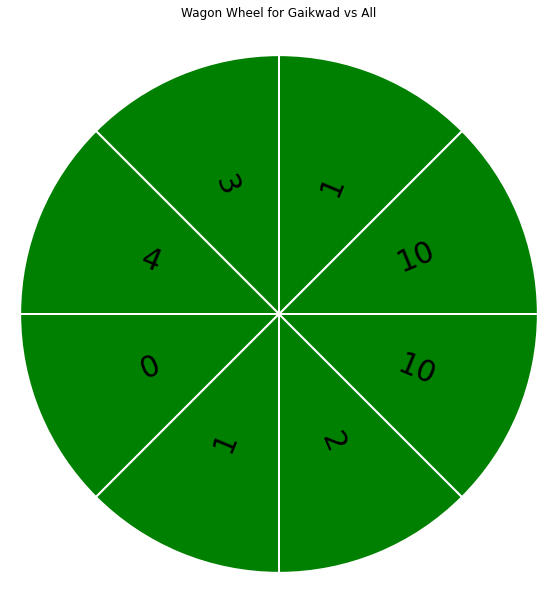

In [15]:
batsman = batsmen_drop.value
bowler = bowler_drop.value
getWagonWheel(batsman, bowler)